# Example of high-level interface

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'

## Toy generative model

In [3]:
def model(z, sigma = .03):
    T = np.array([[1, 1.], [0, 1.], [0, 1.]])
    n = np.random.randn(3)*sigma
    x = T.dot(z) + n
    return x

## Mock data generation

In [4]:
z0 = np.ones(2)*0.5
x0 = model(z0)
print(x0, z0)

[1.00684819 0.53080671 0.47481245] [0.5 0.5]


## Automatic inference 1-dim and 2-dim posteriors

In [5]:
sw = swyft.SWYFT(x0, model, zdim = 2, device = DEVICE)
sw.run(nrounds = 2)
sw.comb([[0, 1]])

100%|██████████| 47/47 [00:00<00:00, 666.91it/s]


Constrained posterior volume: 0.36861399999999994


100%|██████████| 47/47 [00:00<00:00, 663.87it/s]

100%|██████████| 47/47 [00:00<00:00, 677.31it/s]


## Plot posteriors

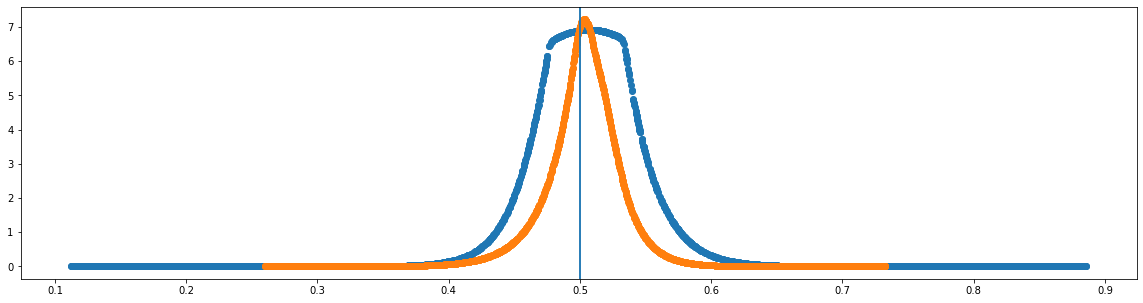

In [6]:
plt.figure(figsize=(20, 5))
for i in range(2):
    zgrid, lnLgrid = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(zgrid[:], np.exp(lnLgrid[:]))

(0.0, 1.0)

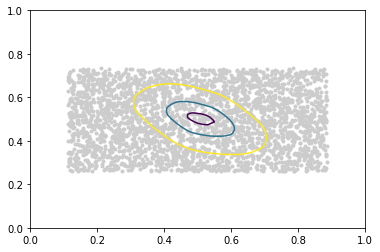

In [7]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])